### Using LLM to evaluate Human vs AI responses to medical quries
This notebook showcases the results of using LLM to evaluate the responses of humans and AI to medical queries.Using visualizations, we can compare the responses of humans and AI to the same medical query. The goal is to see how well the AI is able to provide accurate and relevant information compared to humans.


#### Dependencies: 

Run the cell below to install the required dependencies.

In [ ]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install wordcloud
!pip install textblob
!pip install sklearn
!pip install nltk
!pip install spacy
!pip install gensim

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
path = r"qa_evaluation_results.csv"

In [3]:
df2 = pd.read_csv(path)

- First 5 rows of the dataset: 

In [4]:
df2.head()

,Question,Human_Response,AI_Response,AI_Ranking
0,"about uveitis. IS THE UVEITIS, AN AUTOIMMUNE D...",Uveitis: Uveitis is swelling and irritation of...,Uveitis is a complex and multifaceted ocular i...,8.0
1,"achalasia. after surgery for achalasia, will s...",Gastroesophageal reflux - discharge (Drug Trea...,Achalasia is a primary esophageal motility dis...,9.0
2,Ankle injury. I got hurt in my left leg ankle ...,Earache (Causes): The eustachian tube runs fro...,**Chronic Ankle Pain: Evaluation and Managemen...,9.0
3,Body Lice. How do I get rid of these little de...,Head lice (Causes): Head lice infect hair on t...,**Diagnosis and Treatment of Body Lice (Pedicu...,9.0
4,burn to my wrist. Hello I burnt my wrist 2 day...,Sprains and Strains (Who gets them? Who gets s...,Burn Injury to the Wrist: Assessment and Manag...,9.0


- Dropping the rows with missing values:

In [7]:
df = df2.dropna(subset=['AI_Ranking'])

- ignoring warnings:

In [10]:
import warnings 
warnings.filterwarnings("ignore")

- Distribution of AI Rankings:

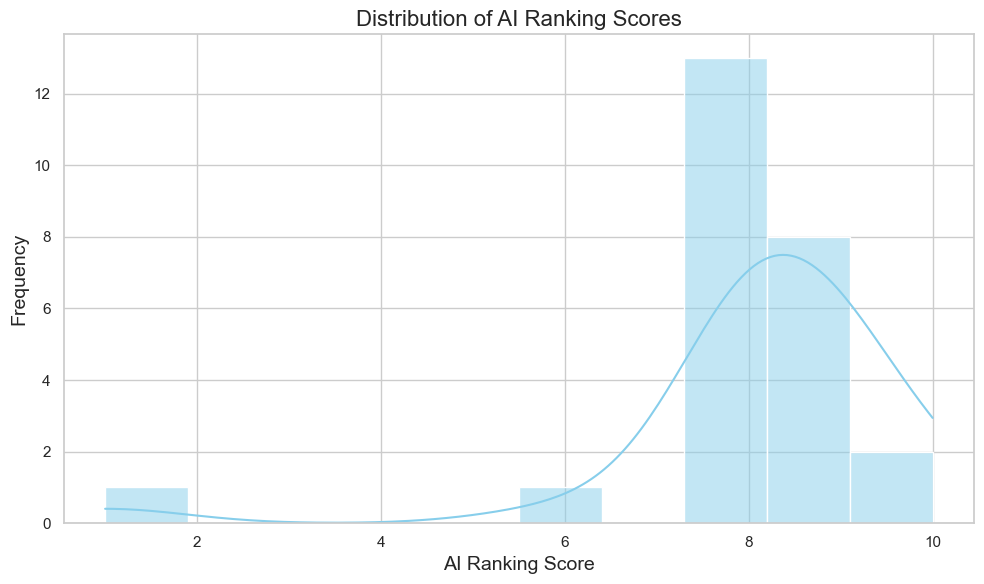

In [8]:
sns.set(style='whitegrid')

plt.figure(figsize=(10,6))
sns.histplot(df['AI_Ranking'], bins=10, kde=True, color='skyblue')

plt.title('Distribution of AI Ranking Scores', fontsize=16)
plt.xlabel('AI Ranking Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.tight_layout()
plt.show()

This histogram visualizes the distribution of AI_Ranking scores across all question-answer pairs. It helps identify how well the AI responses are performing overall compared to human answers. A skew towards higher scores would indicate that AI responses are closely matching human responses in quality.

- Comparison of Response Lengths:

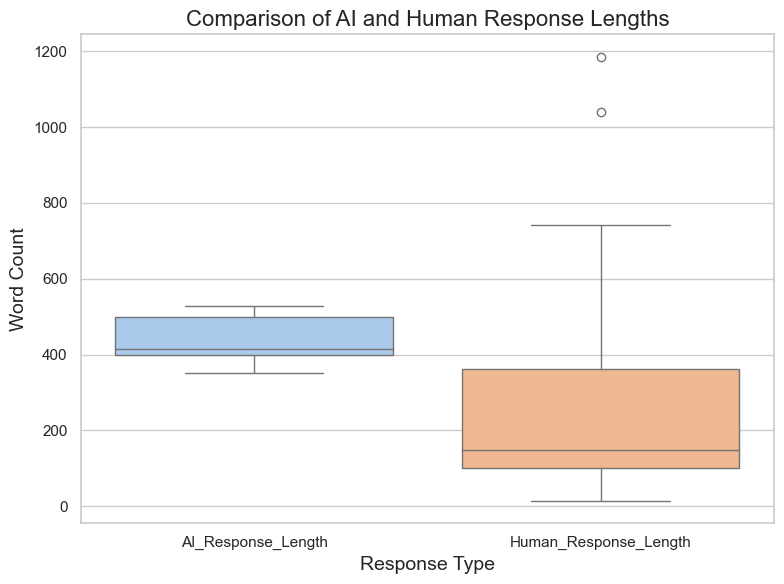

In [11]:
df['AI_Response_Length'] = df['AI_Response'].apply(lambda x: len(str(x).split()))
df['Human_Response_Length'] = df['Human_Response'].apply(lambda x: len(str(x).split()))

length_df = df.melt(value_vars=['AI_Response_Length', 'Human_Response_Length'], 
                    var_name='Response_Type', value_name='Word_Count')

plt.figure(figsize=(8,6))
sns.boxplot(x='Response_Type', y='Word_Count', data=length_df, palette='pastel')

plt.title('Comparison of AI and Human Response Lengths', fontsize=16)
plt.xlabel('Response Type', fontsize=14)
plt.ylabel('Word Count', fontsize=14)

plt.tight_layout()
plt.show()

This box plot compares the lengths of the AI responses and human responses. By analyzing the number of words in each type of response, we can see if the AI tends to be more verbose or concise compared to human experts, which might correlate with the AI_Ranking scores.

- AI Ranking vs. Response Length: 

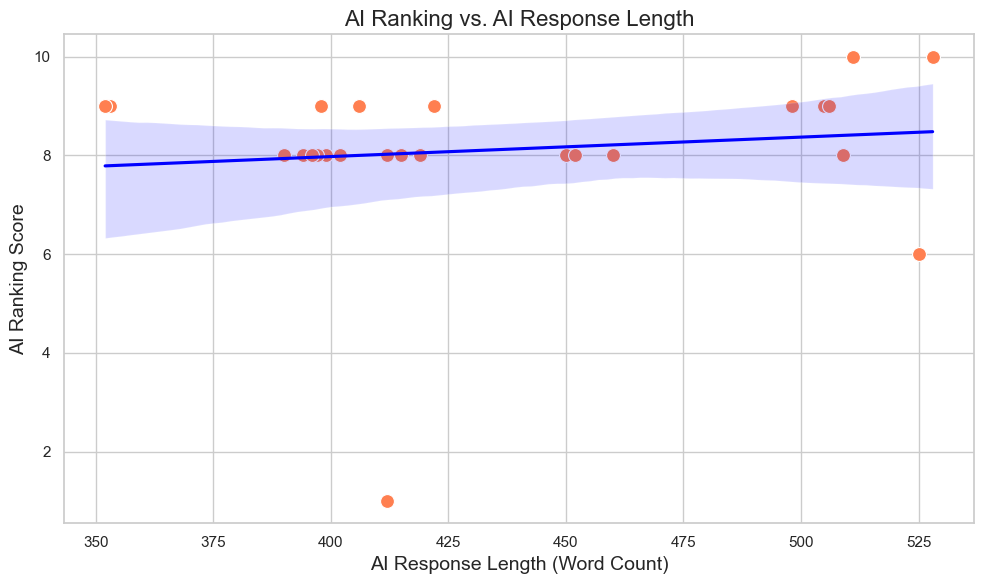

In [ ]:
df['AI_Ranking'] = df['AI_Ranking'].astype(float)

plt.figure(figsize=(10,6))
sns.scatterplot(x='AI_Response_Length', y='AI_Ranking', data=df, color='coral', s=100)

sns.regplot(x='AI_Response_Length', y='AI_Ranking', data=df, scatter=False, color='blue')

plt.title('AI Ranking vs. AI Response Length', fontsize=16)
plt.xlabel('AI Response Length (Word Count)', fontsize=14)
plt.ylabel('AI Ranking Score', fontsize=14)

plt.tight_layout()
plt.show()

This scatter plot examines the relationship between the length of AI responses and their AI_Ranking scores. It helps determine whether longer or shorter AI responses tend to receive higher scores, providing insight into the optimal response length for AI-generated

- Word Cloud of AI Responses:

In [12]:
from wordcloud import WordCloud, STOPWORDS

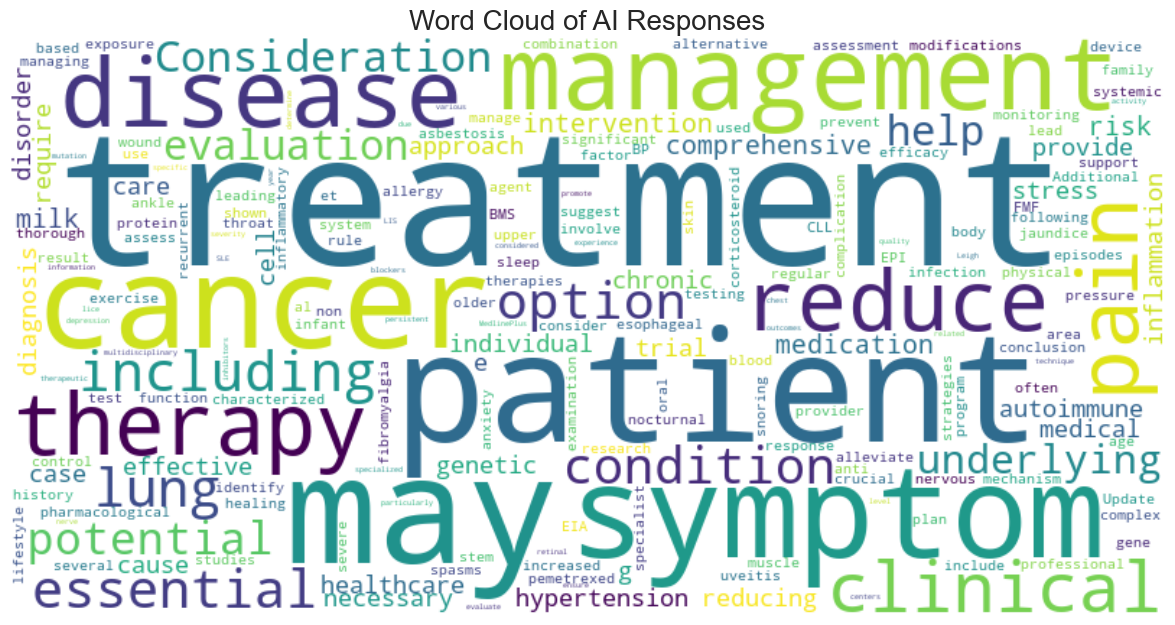

In [16]:
text = ' '.join(df['AI_Response'].dropna().astype(str))

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=stopwords, collocations=False).generate(text)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of AI Responses', fontsize=20)
plt.show()

This word cloud visualizes the most frequent words used in AI responses. It provides a qualitative understanding of the common themes and terminology the AI uses, offering insight into the focus areas and vocabulary richness of the AI-generated answers.

- Sentiment Analysis of AI and Human Responses: 

In [14]:
from textblob import TextBlob

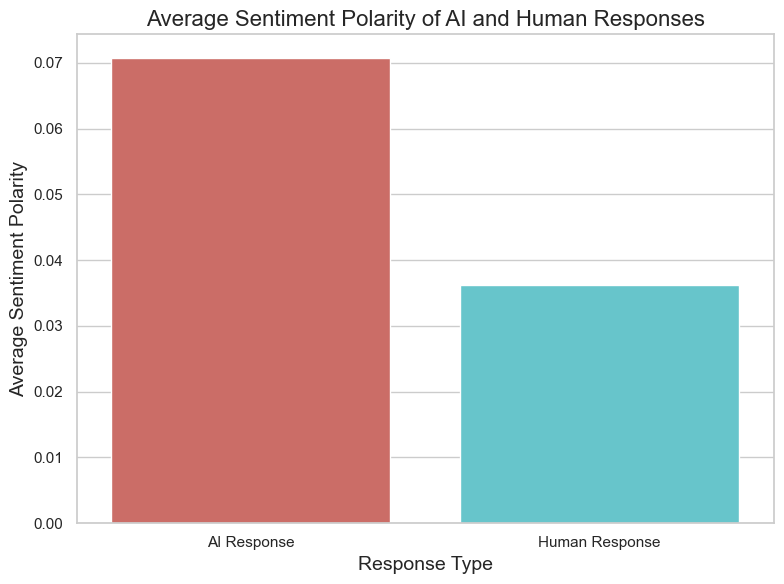

In [15]:
df['AI_Sentiment'] = df['AI_Response'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['Human_Sentiment'] = df['Human_Response'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

avg_sentiments = pd.DataFrame({
    'Response_Type': ['AI Response', 'Human Response'],
    'Average_Polarity': [df['AI_Sentiment'].mean(), df['Human_Sentiment'].mean()]
})

plt.figure(figsize=(8,6))
sns.barplot(x='Response_Type', y='Average_Polarity', data=avg_sentiments, palette='hls')

plt.title('Average Sentiment Polarity of AI and Human Responses', fontsize=16)
plt.xlabel('Response Type', fontsize=14)
plt.ylabel('Average Sentiment Polarity', fontsize=14)

plt.tight_layout()
plt.show()

This bar chart compares the average sentiment polarity of AI responses and human responses. Using NLP sentiment analysis, we can assess whether AI responses convey a more positive, neutral, or negative tone compared to human experts, which could impact the perception of the answers.

- Topic Modeling of Questions Using NLP: 

In [18]:
import gensim
from gensim import corpora
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import nltk

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

In [20]:
stop_words = set(stopwords.words('english'))
texts = df['Question'].dropna().astype(str).tolist()
texts = [gensim.utils.simple_preprocess(text, deacc=True) for text in texts]
texts = [[word for word in text if word not in stop_words] for text in texts]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, passes=15, random_state=42)

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

This interactive pyLDAvis visualization displays the topics extracted from the questions using Latent Dirichlet Allocation (LDA). It helps identify common themes or topics within the dataset of questions, offering insights into the areas of concern or interest among users.

- Heatmap of Correlations Between Numerical Variables: 

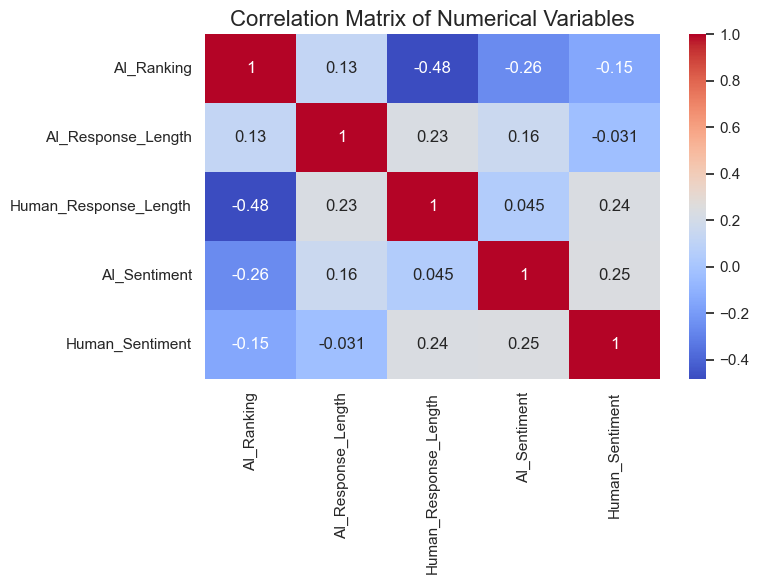

In [ ]:
df = df.dropna(subset=['AI_Ranking'])
df['AI_Ranking'] = df['AI_Ranking'].astype(float)

df['AI_Response_Length'] = df['AI_Response'].apply(lambda x: len(str(x).split()))
df['Human_Response_Length'] = df['Human_Response'].apply(lambda x: len(str(x).split()))

df['AI_Sentiment'] = df['AI_Response'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['Human_Sentiment'] = df['Human_Response'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

numerical_vars = ['AI_Ranking', 'AI_Response_Length', 'Human_Response_Length', 'AI_Sentiment', 'Human_Sentiment']

corr_matrix = df[numerical_vars].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix of Numerical Variables', fontsize=16)

plt.tight_layout()
plt.show()

This heatmap visualizes the correlation matrix between numerical variables in the dataset, such as `AI_Ranking`, `AI_Response_Length`, `Human_Response_Length`, `AI_Sentiment`, and `Human_Sentiment`. It helps identify relationships between these variables, revealing how they may influence each other.

- Comparison of Top 20 Most Common Words: 

In [21]:
from collections import Counter

In [22]:
def get_word_counts(responses):
    words = ' '.join(responses.dropna().astype(str)).lower().split()
    words = [word.strip('.,!?"()') for word in words if word not in stop_words]
    word_counts = Counter(words)
    return word_counts

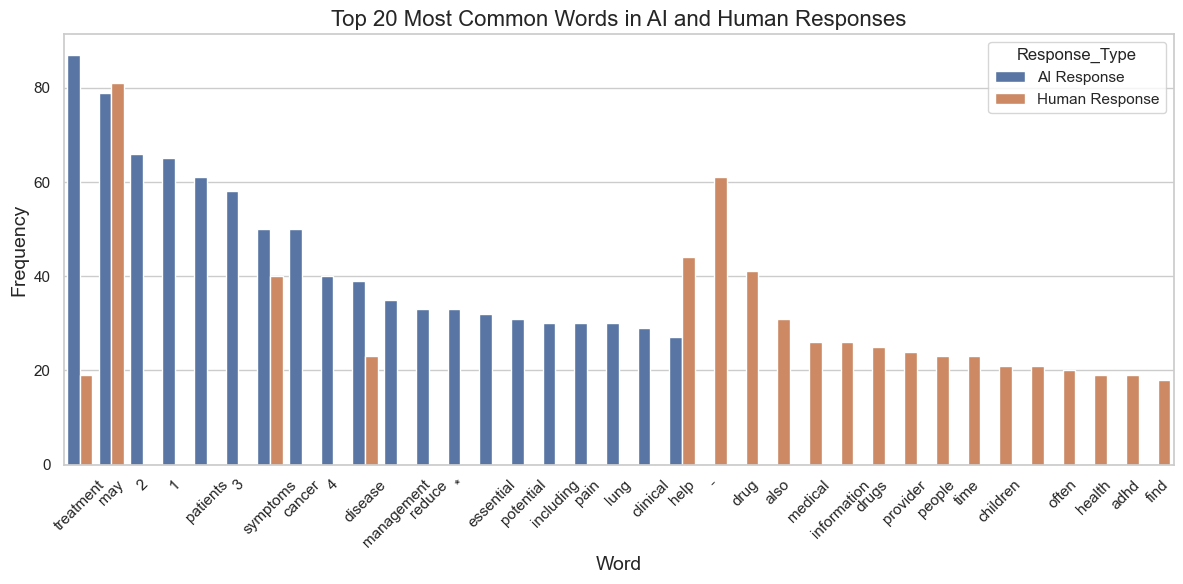

In [23]:
ai_word_counts = get_word_counts(df['AI_Response'])
human_word_counts = get_word_counts(df['Human_Response'])

ai_common = ai_word_counts.most_common(20)
human_common = human_word_counts.most_common(20)

ai_common_df = pd.DataFrame(ai_common, columns=['Word', 'Frequency'])
ai_common_df['Response_Type'] = 'AI Response'

human_common_df = pd.DataFrame(human_common, columns=['Word', 'Frequency'])
human_common_df['Response_Type'] = 'Human Response'

common_df = pd.concat([ai_common_df, human_common_df])

plt.figure(figsize=(12,6))
sns.barplot(x='Word', y='Frequency', hue='Response_Type', data=common_df)

plt.title('Top 20 Most Common Words in AI and Human Responses', fontsize=16)
plt.xlabel('Word', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

This bar chart compares the top 20 most frequently used words in AI responses and human responses (excluding common stopwords). It provides insights into the vocabulary used by the AI and human experts, highlighting any differences or similarities in terminology.

- Pairwise Cosine Similarity of Responses: 

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

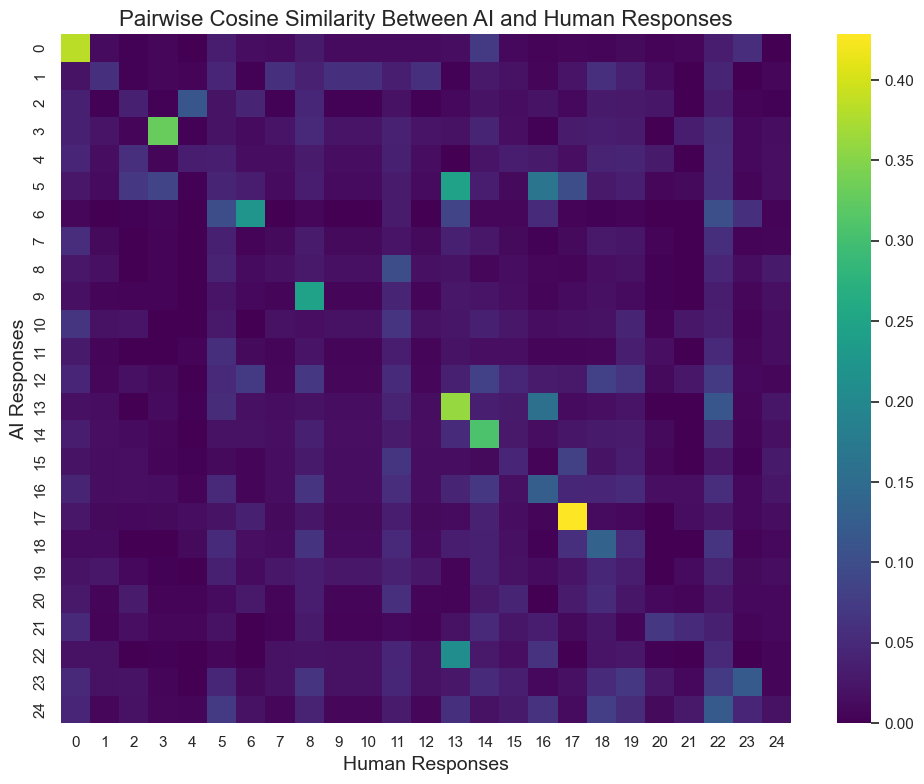

In [25]:
responses = df['AI_Response'].tolist() + df['Human_Response'].tolist()
response_types = ['AI Response'] * len(df) + ['Human Response'] * len(df)

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(responses)

cosine_sim = cosine_similarity(tfidf_matrix[:len(df)], tfidf_matrix[len(df):])

cosine_sim_df = pd.DataFrame(cosine_sim, index=df.index, columns=df.index)

plt.figure(figsize=(10,8))
sns.heatmap(cosine_sim_df, cmap='viridis')

plt.title('Pairwise Cosine Similarity Between AI and Human Responses', fontsize=16)
plt.xlabel('Human Responses', fontsize=14)
plt.ylabel('AI Responses', fontsize=14)

plt.tight_layout()
plt.show()

This heatmap visualizes the pairwise cosine similarity between AI responses and human responses for each question. It provides an insight into how closely the AI responses match the human responses in terms of content, indicating the AI's effectiveness in mirroring expert answers.

- Clustering Questions Based on Semantic Similarity:

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

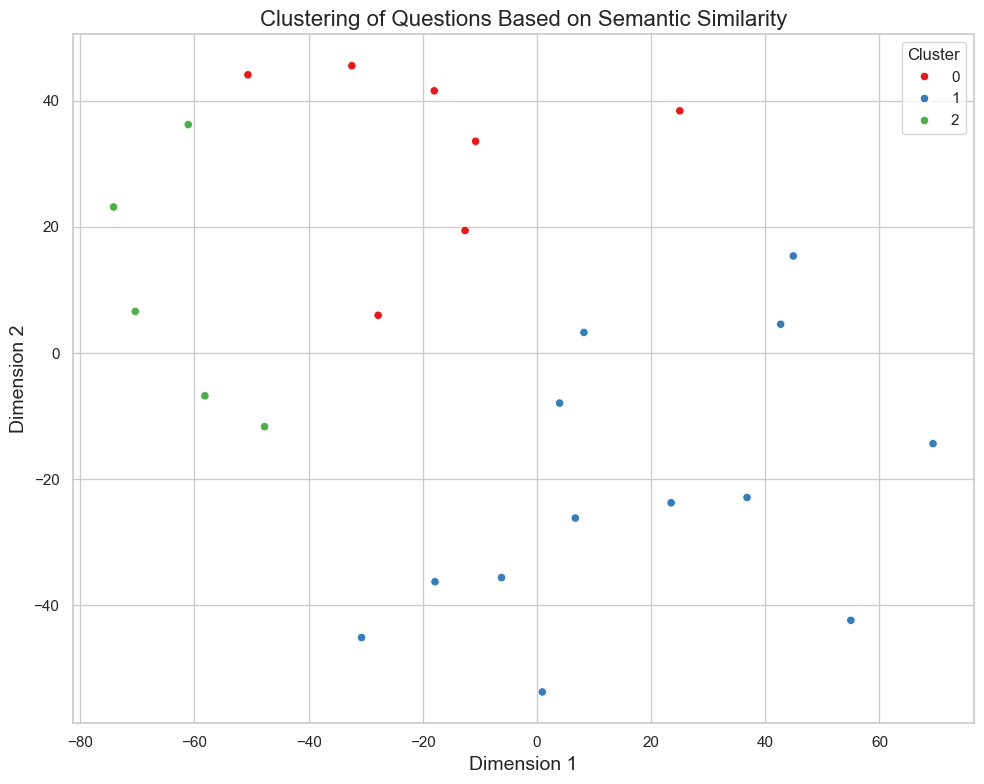

In [27]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Question'])

tsne = TSNE(n_components=2, random_state=42, perplexity=5)
X_embedded = tsne.fit_transform(X.toarray())

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_embedded)

plot_df = pd.DataFrame({
    'x': X_embedded[:,0],
    'y': X_embedded[:,1],
    'Cluster': clusters,
    'Question': df['Question']
})

plt.figure(figsize=(10,8))
sns.scatterplot(x='x', y='y', hue='Cluster', data=plot_df, palette='Set1')

plt.title('Clustering of Questions Based on Semantic Similarity', fontsize=16)
plt.xlabel('Dimension 1', fontsize=14)
plt.ylabel('Dimension 2', fontsize=14)

plt.tight_layout()
plt.show()

This visualization uses t-SNE to project high-dimensional question embeddings into a 2D space, then clusters them using K-Means clustering. It helps identify groups of similar questions, revealing common themes or topics within the dataset.